In [11]:
import sys
import os
from argparse import Namespace
import deepchem as dc
from rdkit import Chem
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_auc_score, mean_absolute_error, mean_squared_error, log_loss, accuracy_score, f1_score
from ogb.lsc import PCQM4Mv2Dataset
import pickle
import pandas as pd
import numpy as np
import scipy.sparse as sp
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import auc, accuracy_score, f1_score, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import torch

sys.path.append('../codes/models/GNN/')
from fingerprint_model import get_fingerprint_GNN


In [5]:
def save_numpy(path, obg):
    with open(path, 'wb') as f:
        np.save(f, obg)

In [7]:
datasets = ['nitro_data']


In [8]:
checkpoint = '../../evalgnn/Prob_LS/checkpoints/gcn_virtual/checkpoint.pt'
res={}
for dataset_name in datasets:
    dataset = pd.read_csv(f'../Datasets/Pairwise_Datasets/pair_ds/{dataset_name}.csv')
    if len(dataset) > 10000:
        dataset= dataset.iloc[0:10000]
    
    w_smiles = dataset.iloc[:,0].tolist()
    wo_smiles = dataset.iloc[:,1].tolist()
    w_fg = get_fingerprint_GNN(w_smiles, 'gcn-virtual', checkpoint, batch_size=128 )
    wo_fg = get_fingerprint_GNN(wo_smiles, 'gcn-virtual', checkpoint, batch_size=128)
    save_numpy(f'./pairemb/GCNV_wfg_{dataset_name}.npy', w_fg)
    save_numpy(f'./pairemb/GCNV_wofg_{dataset_name}.npy', wo_fg)
    print(dataset_name)

../../evalgnn/Prob_LS/checkpoints/gcn_virtual/checkpoint.pt


Iteration: 100%|████████████████████████████████████| 79/79 [00:07<00:00, 11.05it/s]


../../evalgnn/Prob_LS/checkpoints/gcn_virtual/checkpoint.pt


Iteration: 100%|████████████████████████████████████| 79/79 [00:06<00:00, 11.92it/s]


nitro_data


In [20]:
def linear_probing(embedding, property, seed=0, percent_train=0.8, scale=True, return_predictor=False):
    np.random.seed(seed)
    
    n_train = int(percent_train*len(property))
    rnd = np.random.permutation(len(property))
    idx_train, idx_test = rnd[:n_train], rnd[n_train:]

    idx_train, idx_test = train_test_split(np.arange(embedding.shape[0]),
                                           train_size=percent_train,
                                           stratify=property)

    train = embedding[idx_train]
    test = embedding[idx_test]

    if scale:
        scaler = preprocessing.StandardScaler(with_mean=not sp.issparse(embedding))
        train = scaler.fit_transform(train)
        test = scaler.transform(test)
    
    lr = LogisticRegression(verbose=False, max_iter=2000)
    lr.fit(train, property[idx_train])

    y_proba = lr.predict_proba(test)
    y_pred = y_proba.argmax(1)

    if return_predictor:
        return (accuracy_score(y_pred, property[idx_test]), f1_score(y_pred, property[idx_test], average='macro'), roc_auc_score(property[idx_test], y_proba[:, 1])),lr
    else:
        return accuracy_score(y_pred, property[idx_test]), f1_score(y_pred, property[idx_test], average='macro'), roc_auc_score(property[idx_test], y_proba[:, 1])

In [28]:
def plot_pca(embd_source, embd_target, ax, acc, auc, ATE_lr, ATE_PA, Pairwise_cs, n_components=10):
    embd_mean = (embd_source + embd_target)/2
    norm_embd_source = embd_source - embd_mean
    norm_embd_target = embd_target - embd_mean

    pca = PCA(n_components=n_components)
    transformed = pca.fit_transform(np.vstack((norm_embd_source, norm_embd_target)))
    sns.set_theme(style='darkgrid', palette='colorblind')



    sns.set(font_scale=1)
    sns.scatterplot(*transformed[:, :2].T, s=40, hue=state, alpha=0.8, ax=ax[0], style=state, palette=sns.color_palette('colorblind', n_colors=2))
    ax[0].set_ylabel('2nd Principal Component',  font={'size': 20})

    ax[0].set_title(f'AUC : {auc: .2f}',  font={'size': 20})

    sns.barplot(x= np.arange(n_components), y=pca.explained_variance_ratio_, ax=ax[1], color='black')
    ax[1].set_ylabel('Variance Ratio',  font={'size': 20})
    ax[1].set_title('$C_{ate}^{pair}$:'+f'{ATE_pairwise: .2f}',  font={'size': 20})


    emdb_diff = embd_source-embd_target
    sns.histplot(cosine_similarity(emdb_diff)[np.tril_indices(emdb_diff.shape[0], k=-1)], ax=ax[2],color='black',stat='probability');

    ax[2].set_ylabel('Probability',  font={'size': 20})
    ax[2].set_title(f'Average Pairwise Cos-sim : {pairwise: .2f}' , font={'size': 20})

    ax[0].legend(prop={'size': 15})

    ax[0].tick_params(axis='both', which='major', labelsize=15)
    ax[1].tick_params(axis='both', which='major', labelsize=15)
    ax[2].tick_params(axis='both', which='major', labelsize=15)
    ax[2].ticklabel_format( axis="y", style="sci", )



#   ax[1].set_title(title)

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


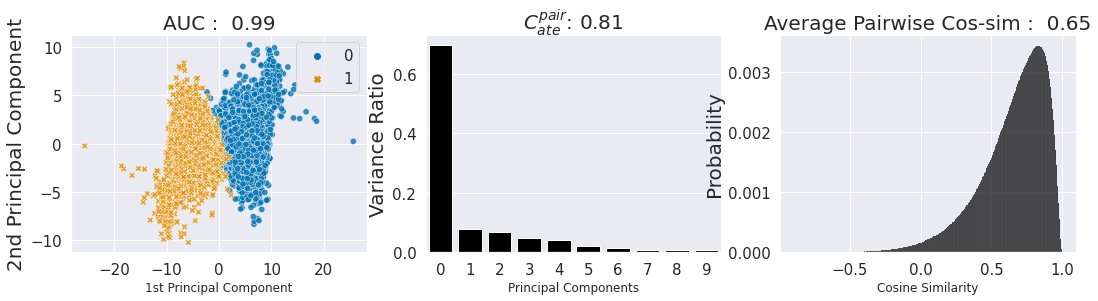

In [31]:
dataset = 'nitro'
models= ['GCNV']
fig, ax = plt.subplots(len(models), 3, figsize=(6*3, 4* len(models)))
ax[0].set_xlabel('1st Principal Component')
ax[1].set_xlabel('Principal Components')
ax[2].set_xlabel('Cosine Similarity')


for i, model in enumerate(models):
    embd_source = np.load(f'./pairemb/{model}_wfg_{dataset}_data.npy')[-1][:]
    embd_target = np.load(f'./pairemb/{model}_wofg_{dataset}_data.npy')[-1][:]
    embd_all = np.vstack((embd_source,
                        embd_target
                         ))
    state = np.repeat([0, 1], embd_source.shape[0])

    probing_res, lr = linear_probing(embd_all, state, return_predictor=True)
    v_ate = np.mean(embd_target - embd_source, axis=0)
   
    ATE_lr = cosine_similarity(v_ate.reshape(1,-1), lr.coef_)
    
    emdb_diff = embd_target - embd_source
    ATE_pairwise = cosine_similarity(emdb_diff, v_ate.reshape(1,-1)).mean()
   
    pairwise= cosine_similarity(emdb_diff)[np.tril_indices(emdb_diff.shape[0], k=-1)]
    pairwise = pairwise.mean()

    plot_pca(embd_source, embd_target, ax, probing_res[0], probing_res[2], ATE_lr,ATE_pairwise, pairwise)
